# Load & Prepare Data

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 11.4 MB/s eta 0:00:00


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import xml.etree.ElementTree as ET
import shutil
import tensorflow as tf
import wandb
wandb.login(key= "7f57f2919952083b65dd6978e611ea7a88a22160" )
from sklearn.model_selection import *
from ultralytics import YOLO

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# train and test paths
train_path = '/content/images/train/'
test_path = '/content/images/test/'
classes = ['apple','banana' ,'orange']

In [4]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size')
  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)
  bounding_boxes=[]
  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))
    class_name = object_tree.find('name').text
    class_dict={classes[i]:i for i in range(len(classes))}
    if width == 0 : width =+700
    if height == 0 : height =+700
    bounding_box = [
      class_dict[class_name],(xmin+xmax)/(2*width),(ymin+ymax)/(2*height),(xmax-xmin)/width,
        (ymax-ymin)/height]
    bounding_boxes.append(bounding_box)
  return tf.convert_to_tensor(bounding_boxes)

In [5]:
train_dir = sorted(os.listdir(train_path))
images_name = []
xml_name = []
for path in train_dir:
  if path.split('.')[-1] == 'jpg':images_name.append(path)
  else:xml_name.append(path)

In [6]:
train_images_name , val_images_name , train_xml_name , val_xml_name = train_test_split(images_name , xml_name ,
                                                                                test_size = 0.2,random_state = 42)


In [7]:
train_images , train_xml ,val_images , val_xml = [],[],[],[]
bboxes_visualize = []
for tr_i in range(len(train_images_name)):
  img = cv2.imread(train_path + train_images_name[tr_i],1)
  img = cv2.resize(img,(224,224))
  train_images.append(img)
  bbox = preprocess_xml(train_path + train_xml_name[tr_i])
  train_xml.append(bbox)
for vl_i in range(len(val_images_name)):
  img = cv2.imread(train_path + val_images_name[vl_i],1)
  img = cv2.resize(img,(224,224))
  val_images.append(img)
  bbox = preprocess_xml(train_path + val_xml_name[vl_i])
  val_xml.append(bbox)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


/tmp/ipykernel_20/2878887082.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,5,i+1)


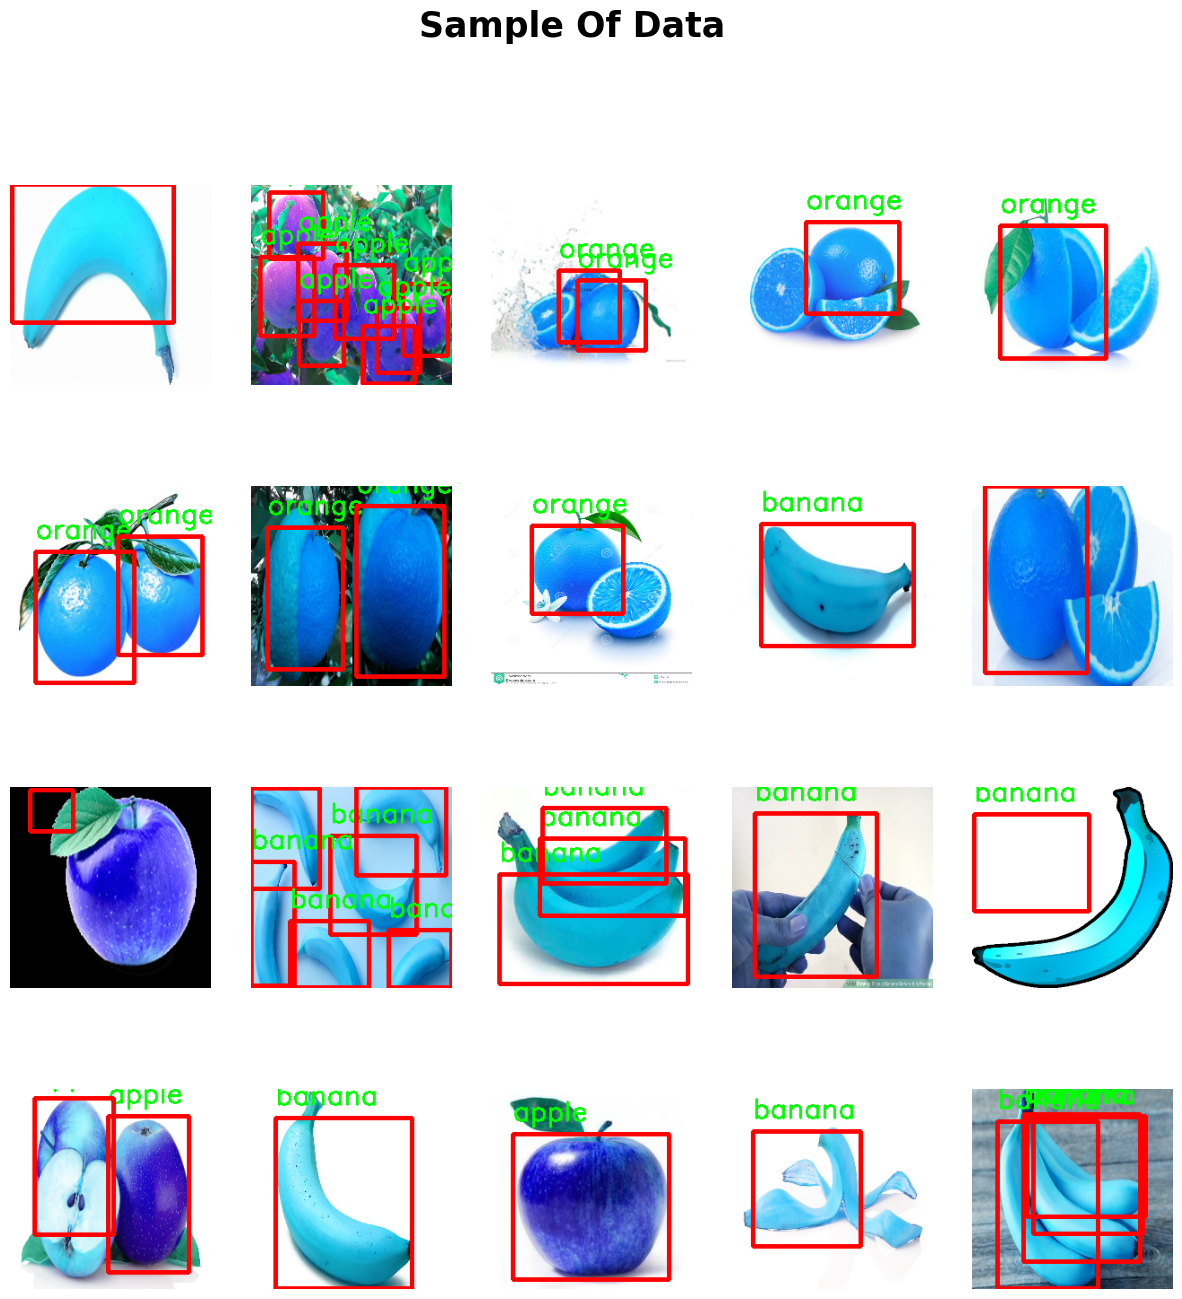

In [8]:
n_images = 20
fig,axs = plt.subplots(figsize = (15,15))
fig.suptitle('Sample Of Data',fontweight = 'bold' , fontsize = 25 ,ha = 'center')
for i in range(n_images):
  plt.subplot(4,5,i+1)
  for j in range(len(train_xml[i])):
    w = int(train_xml[i][j][3]*224)
    h = int(train_xml[i][j][4]*224)
    xc = int(train_xml[i][j][1]*224)
    yc = int(train_xml[i][j][2]*224)
    xmin = xc - (w//2)
    ymin = yc - (h//2)
    xmax = xc + (w//2)
    ymax = yc + (h//2)
    cv2.rectangle(train_images[i],(xmin,ymin),
        (xmax,ymax),(255,0,0),3)
    cv2.putText(train_images[i], classes[int(train_xml[i][j][0])], (int(xmin), int(ymin - 15)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
  plt.imshow(train_images[i]/255)
  plt.axis('off')

In [9]:
# make files txt
train_txt , val_txt = [] ,[]
for n in train_images_name:
    name = n.split('.')[0]+'.txt'
    train_txt.append(name)

for n in val_images_name:
    name = n.split('.')[0]+'.txt'
    val_txt.append(name)

for idx,arry in enumerate(train_xml):
  with open(train_txt[idx], "w") as file:
    for arr in arry:
     arr_np = arr.numpy()
     arr_flattened = arr_np.flatten()
     arr_str = arr_flattened.astype(str)
     line = ' '.join(arr_str) + "\n"
     file.write(line)  # Add a newline character after each element
for idx,arry in enumerate(val_xml):
  with open(val_txt[idx], "w") as file:
    for arr in arry:
     arr_np = arr.numpy()
     arr_flattened = arr_np.flatten()
     arr_str = arr_flattened.astype(str)
     line = ' '.join(arr_str) + "\n"
     file.write(line)  # Add a newline character after each element

In [10]:
# make dir
dir_path = '/kaggle/working/data'
dir_train_path = '/kaggle/working/data/train'
dir_val_path = '/kaggle/working/data/val'
dir_train_images_path = '/kaggle/working/data/train/images'
dir_val_images_path = '/kaggle/working/data/val/images'
dir_train_labels_path = '/kaggle/working/data/train/labels'
dir_val_labels_path = '/kaggle/working/data/val/labels'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    os.makedirs(dir_train_path)
    os.makedirs(dir_val_path)
    os.makedirs(dir_train_images_path)
    os.makedirs(dir_train_labels_path)
    os.makedirs(dir_val_images_path)
    os.makedirs(dir_val_labels_path)
for f1 , f2 in zip(train_images_name,train_txt):
    # Check if the file is an image (you can customize this check)
    if f1.endswith((".jpg", ".jpeg", ".png", ".gif")):
        source_file1 = os.path.join(train_path, f1)
        source_file2 = os.path.join('/kaggle/working', f2)
        destination_file1 = os.path.join(dir_train_images_path, f1)
        destination_file2 = os.path.join(dir_train_labels_path, f2)
        # Copy the image file to the new directory
        shutil.copy2(source_file1, destination_file1)
        shutil.copy2(source_file2, destination_file2)

for f1 , f2 in zip(val_images_name,val_txt):
    # Check if the file is an image (you can customize this check)
    if f1.endswith((".jpg", ".jpeg", ".png", ".gif")):
        source_file1 = os.path.join(train_path, f1)
        source_file2 = os.path.join('/kaggle/working', f2)
        destination_file1 = os.path.join(dir_val_images_path, f1)
        destination_file2 = os.path.join(dir_val_labels_path, f2)

        # Copy the image file to the new directory
        shutil.copy2(source_file1, destination_file1)
        shutil.copy2(source_file2, destination_file2)

# Model

In [11]:
with open("/kaggle/working/data.yaml", "w") as file:

    file.write("train: /kaggle/working/data/train\n")
    file.write("val: /kaggle/working/data/val\n")
    file.write("\n")
    file.write("nc: 3\n")
    file.write("names: ['apple','banana' ,'orange']\n")


In [12]:
model = YOLO('yolov8n.pt')
model.train(data = '/kaggle/working/data.yaml',epochs = 50 , imgsz = 224 )

100%|██████████| 6.23M/6.23M [00:00<00:00, 82.0MB/s]
Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, box

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dba31289810>
fitness: 0.5584251464327484
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.76929,     0.47377,     0.35687])
names: {0: 'apple', 1: 'banana', 2: 'orange'}
plot: True
results_dict: {'metrics/precision(B)': 0.8165772160393515, 'metrics/recall(B)': 0.7549961700804575, 'metrics/mAP50(B)': 0.7844548551235455, 'metrics/mAP50-95(B)': 0.5333107343559932, 'fitness': 0.5584251464327484}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.1930147409439087, 'inference': 19.542401035626728, 'loss': 0.00017881393432617188, 'postprocess': 0.7280061642328898}

In [13]:
metrics = model.val()
results = model.predict(source = test_path , save = True , conf = 0.5, show = True)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients
val: Scanning /kaggle/working/data/val/labels.cache... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                   all         48         92      0.784      0.791      0.787      0.537
                 apple         48         29      0.883      0.966      0.974       0.77
                banana         48         30      0.725      0.792      0.833       0.48
                orange         48         33      0.744      0.617      0.552      0.362
Speed: 0.2ms preprocess, 18.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/60 /kaggle/input/fruit-imag

In [14]:
metrics

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dba2fb42b90>
fitness: 0.5620351158432987
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.76955,     0.48017,     0.36154])
names: {0: 'apple', 1: 'banana', 2: 'orange'}
plot: True
results_dict: {'metrics/precision(B)': 0.7842003103245059, 'metrics/recall(B)': 0.7914274067320571, 'metrics/mAP50(B)': 0.7865710250407684, 'metrics/mAP50-95(B)': 0.5370866814880243, 'fitness': 0.5620351158432987}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.16248226165771484, 'inference': 18.28765869140625, 'loss': 0.00022351741790771484, 'postprocess': 0.7549325625101725}

In [15]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'apple', 1: 'banana', 2: 'orange'}
 orig_img: array([[[229, 230, 204],
         [231, 232, 206],
         [240, 239, 213],
         ...,
         [131, 202, 192],
         [160, 237, 230],
         [135, 214, 211]],
 
        [[223, 221, 197],
         [224, 222, 198],
         [235, 233, 209],
         ...,
         [103, 169, 157],
         [145, 218, 208],
         [130, 210, 203]],
 
        [[215, 211, 187],
         [218, 212, 189],
         [236, 230, 207],
         ...,
         [ 75, 134, 119],
         [129, 198, 185],
         [136, 214, 203]],
 
        ...,
 
        [[ 46,  81,  71],
         [ 86, 136, 126],
         [ 98, 160, 154],
         ...,
         [  1,  46,  27],
         [ 23,  76,  56],
         [ 49, 108,  88]],
 
        [[ 57,  92,  78],
         [ 76, 122, 110],
         [ 82, 139, 130],
         ...,
    